# Exploring the Pegasus Topology
D-Wave's commercial quantum computer, Advantage, is based on a quantum processing unit (QPU) with a complex architecture: the Pegasus family of [topologies](https://docs.dwavesys.com/docs/latest/c_gs_4.html). This notebook describes the Pegasus topology and shows how it enables superior performance to previous generations of quantum computers. 
    
1. [The Pegasus Advantage](#The-Pegasus-Advantage) demonstrates and explains the performance differences between the previous and current QPU architectures.
2. [Navigating the Topology](#Navigating-the-Topology) describes the Pegasus topology and presents Ocean tools that help you use it.
3. [Example Problem: RANr](#Example-Problem:-RANr) solves a hard problem on an Advantage quantum computer.

This notebook should familiarize you with the Pegasus topology and the tools to use it.

<img src="images/anim.gif" width=200x/>

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# The Pegasus Advantage

The Advantage system is distinct from all previous generations of D-Wave's quantum computers in employing an architecture made possible by advances in QPU fabrication technology. 

QPUs are lattices of interconnected qubits. While some qubits connect to others via couplers, QPUs are not fully connected. Instead, qubits interconnect in a topology: the Advantage topology is called *Pegasus*.

QPU topology is crucial to *embedding* problems onto quantum computers, determining what problems can be addressed and affecting the quality of solutions. Pegasus topology was designed for the real-world problems of business applications.

## Minor-Embedding: Mapping Problems to Qubits

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: If you already understand how problems are mapped to the D-Wave system, please skip ahead to the next text cell by clicking the **Run** button.</div>
 
D-Wave quantum computers solve binary quadratic models (BQMs): the [Ising model](https://en.wikipedia.org/wiki/Ising_model) traditionally used in statistical mechanics and its computer-science equivalent, the quadratic unconstrained binary optimization ([QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)) problem. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the system finds assignments of values that minimize the QUBO,

$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,

where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients. 

Such [objective functions](https://docs.ocean.dwavesys.com/en/stable/concepts) can be represented by graphs. A graph comprises a collection of nodes, representing variables, and edges representing the connections between them. For example, a Boolean AND, $z \Leftrightarrow x_1 \wedge x_2$, expressed in [QUBO formulation](https://docs.dwavesys.com/docs/latest/c_handbook_3.html) as, 

$x_1 x_2 - 2(x_1+x_2)z +3z$, 

is represented by the graph:

<img src="images/embedding_and.png" width=300x/>

Linear coefficients (e.g., the $3$ multiplying variable $z$) are represented as node values while quadratic coefficients (e.g., the $-2$ multiplying the interaction of variables $x_1z$) are represented as edge weights. 

To formulate a problem for a D-Wave quantum computer, by programming $q_i$ and $q_{i,j}$ so that assignments of $x_1,...,x_N$ also represent solutions to the problem, requires that the problem graph be mapped to the QPU. [Minor embedding](https://docs.ocean.dwavesys.com/en/stable/concepts/embedding.html#embedding-sdk) maps problem variables ($x_1, x_2, z$ for the AND gate) to the indexed qubits of the D-Wave QPU, with node values represented by qubit biases and edge values by coupler strengths.

Were the QPU topology fully connected&mdash;a fully-connected graph, or *clique*, is one in which every node shares an edge with every other node, and in the case of QPU topology, every qubit would be coupled to every other qubit&mdash;you could simply map each problem variable (graph node) to any arbitrary qubit and each quadratic interaction (graph edge) to a coupler. 

With sparser QPU topologies, you might need to represent some variables as *chains* of two or more qubits in order to couple their representative qubits. For example, the Boolean AND, represented by a fully connected graph of three nodes, $K_3$, shown on the left side of the figure below, cannot be mapped directly to qubits in the Chimera topology used by previous QPUs. Instead, the graph is mapped to four qubits that are coupled so two qubits (e.g., 0 and 4 here) form a chain to represent one variable (here $z$), as shown in the middle and right parts of the figure.

<img src="images/embedding_chimera_and.png" width=500x/>

The strength of couplers between qubits in a chain is set to correlate the qubits strongly, so that in most solutions they have a single value for the variable they represent. 

[Ocean software](https://docs.ocean.dwavesys.com/en/stable/index.html) provides tools that handle minor-embedding. One instance of minor-embedding a $K_5$ problem on an Advantage is displayed below in the [dwave-inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) tool. The problem graph, shown on the left, is embedded in six qubits, shown on the right against a background of the Pegasus topology. Variable ``0``, highlighted in dark magenta, is represented by two qubits, ``4408`` and ``2437`` in this particular embedding.

<img src="images/embedding_5var6qubits.png" width=500x/>

The size and complexity of problems that can be submitted to a quantum computer depends on the QPU's *working graph*, the set of qubits and couplers that are available for computation. Adding qubits expands the QPU's range, obviously, but  denser connectivity reduces the allocation of multiple qubits to chains representing single variables. Long chains can also degrade solution quality. 

The Pegasus topology enables the Advantage QPU to more than double the number of available qubits compared to the previous D-Wave 2000Q quantum computer, and the working graph is denser, meaning each qubit is coupled to a greater number of neighboring qubits. 

## More Qubits and Denser Connectivity
When looking at summary differences between generations of QPUs, one naturally tends to first notice the increase in number of qubits. The earlier D-Wave 2000Q quantum computer had over 2,000 while the Advantage has over 5,000. That increase is important; this notebook shows why connectivity deserves your attention too.   

This section also introduces useful Ocean software tools that let you work and experiment with the QPU topology locally on your computer. Unless you are solving a problem, as section [Example Problem: RANr](#Example-Problem:-RANr) does, you can explore the topology without needing to access a system.

Ocean's [dwave_networkx](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) is an extension of [NetworkX](http://networkx.github.io/)&mdash;a Python language package for exploration and analysis of networks and network algorithms&mdash;for D-Wave systems. It provides tools for working with Chimera and Pegasus graphs. 

*dwave_networkx* provides functionality to create Chimera and Pegasus lattices of varying sizes. This first code cell creates Chimera and Pegasus graphs of size CN $=$ C16 and PN $=$ P16. 

The notation CN refers to a Chimera lattice consisting of an $NxN$ grid of *unit cells*. Unit cells are described in more detail below; for now it's sufficient to think of them as vertically and horizontally tiled, sparsely connected, groups of more densely connected qubits. The D-Wave 2000Q had a C16 lattice, meaning a grid of $16x16$ unit cells. The Advantage has a P16 lattice that is explored below. 



In [1]:
import dwave_networkx as dnx

chimera_16 = dnx.chimera_graph(16)
pegasus_16 = dnx.pegasus_graph(16)

print("Qubits in a full working graph: \n    D-Wave 2000Q Chimera C16: {}\n    Advantage Pegasus P16: {}".format(
      len(chimera_16.nodes), len(pegasus_16.nodes)))

Qubits in a full working graph: 
    D-Wave 2000Q Chimera C16: 2048
    Advantage Pegasus P16: 5640


Due to manufacturing variations and the need to prepare the QPU to operate at cryogenic temperatures in a low–magnetic field environment, the number of qubits available for computation on a QPU (the working graph's *yield*) is typically a bit lower than the maximum for the lattice size. These Ocean tools can also generate incomplete working graphs, as is done below in this notebook.

*dwave_networkx* also provides graphing functions to visualize topologies. Notice the difference in density of qubits (green dots) and connectivity (black edges) between the two $16x16$ lattices below. 

Text(0.5, 1.0, 'Pegasus P16')

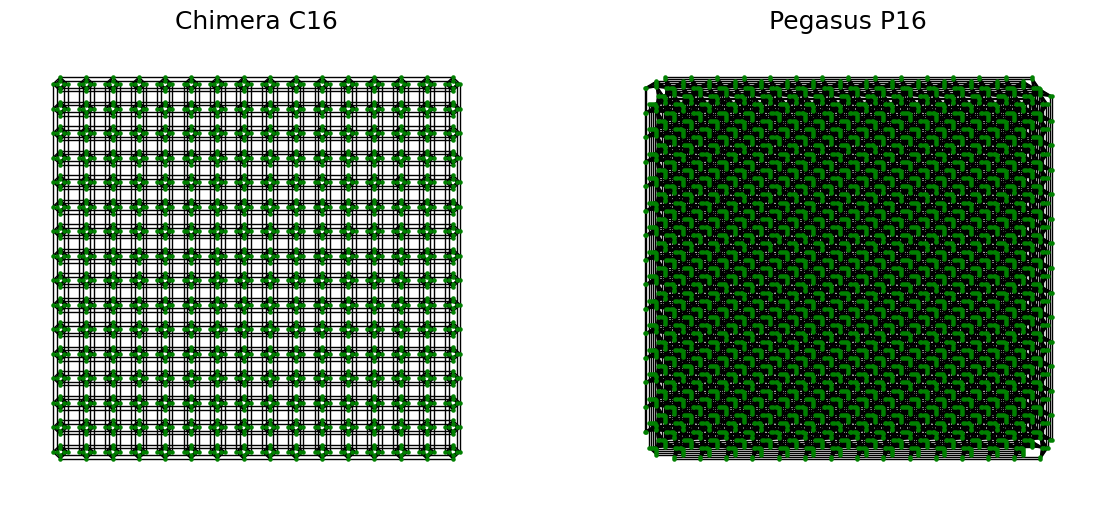

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(14,6))

dnx.draw_chimera(chimera_16, ax=ax[0], node_size=5, node_color='g')
ax[0].set_title('Chimera C16', fontsize=18)

dnx.draw_pegasus(pegasus_16, ax=ax[1], node_size=5, node_color='g')
ax[1].set_title('Pegasus P16', fontsize=18)

## Test Case: Embedding Random Graphs 
Advantage was developed to meet D-Wave customers' need for increased capability to embed larger and more complex problems. The resulting Pegasus topology enables the embedding of problems with shorter chains, which can result in higher quality solutions, as demonstrated in section [Example Problem: RANr](#Example-Problem:-RANr).  

To demonstrate the benefits of the Pegasus topology, the following subsections compare its performance with that of the Chimera. This is done by generating and embedding many random graphs that are representative of problems of sizes commensurate with the size of a D-Wave 2000Q QPU.   

<div class="alert alert-warning" role="alert" style="margin: 10px">The demonstrations of this section do not submit problems to a D-Wave system for solution, and so are not associated with a cost for QPU usage time.</div>

The next three code cells import three functions used throughout this section. You can see (and modify) the code for these functions in the ``helpers`` folder of this example's repository.

* `random_graph` generates a random graph for the number of nodes and edges per node you specify.
* `try_embedding` tries to embed given graphs in both Chimera and Pegasus topologies. 
* `embedding_loop` runs in a loop over the other two functions for a set of graph sizes and configurable embedding parameters. 

First, import and use the `random_graph` function to create a small random graph with 100 nodes and 2 edges per node.

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.embed import random_graph
import networkx as nx
import dimod 

G = random_graph(nodes=100, edges=2)

The three images of this cell give physical form to the connection between such a random graph and the submission of a problem to a quantum computer. For the graph below, that resulted from one execution of the `random_graph` function, a problem was generated by setting random values on its edges. Submitting this problem to two quantum computers produced the embeddings shown by the [dwave-inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) tool. 

<img src="images/random_graph_100_2.png" width=300x/>

An embedding on a D-Wave 2000Q:
<img src="images/c16_random_graph_100_2.png" width=700x/>

An embedding on an Advantage:
<img src="images/p16_random_graph_100_2.png" width=700x/>

Such graphs can represent any problem you might want to solve on a quantum computer. Successful, efficient embedding determines whether you can do so. 

The second function, `try_embedding`, uses one of Ocean's embedding tools to find a minor-embedding for a given problem. You can configure the number or attempts this heuristic algorithm makes, `tries`, and a timeout value for those attempts, `timeout`. 

<div class="alert alert-warning" role="alert" style="margin: 10px">You can also update the code (located in the <code>helpers</code> folder for this notebook) to configure additional embedding parameters, described here: <a href=\"https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html\">minorminer</a>.</div>
Run it on the graph you generated in the previous code cell:

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.embed import try_embedding
import minorminer

topologies_16 = {'Chimera': chimera_16, 'Pegasus': pegasus_16}

try_embedding(source_graph=G, 
              target_graphs=topologies_16, 
              timeout=20, 
              tries=2)

The `try_embedding` function returns for both QPU topologies the longest chain it needed for the embedding. As mentioned above, for a group of qubits to act as a chain, you need to strongly couple them so that they tend to return a single value for the variable the chain represents. In this context "strong" is relative to values used for the problem's quadratic interactions, which are also represented by coupling strengths. Because coupling values have a finite range, relatively strong, long chains can come at the [cost](https://docs.dwavesys.com/docs/latest/c_handbook_6.html) of a smaller range of coupling strengths for representing the problem's quadratic interactions. 

The last of the three functions,`embedding_loop`, runs the two previous ones and saves some of the parameters and results in a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) data structure for convenient analysis.

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.embed import embedding_loop
import pandas as pd

embedding_loop(nodes=10,   # Additional configuration parameters are demonstrated below
               edges=5, 
               target_graphs=topologies_16)  

By default, `embedding_loop` generates two graphs for the given graph size and makes two embedding attempts for each topology. 

For graphs that are not very small, the performance of an embedding heuristic can vary significantly; some instances of the graphs generated by the `random_graph` function for particular input parameters might perform better on the Chimera topology, some on the Pegasus. For meaningful insight into the relative performance, one needs a statistically sufficient number of trials.  

Results for large numbers of trials for some graph sizes are presented below. You can increase the number of graphs for sizes that interest you.      

## Performance on Sparse Graphs
A graph is considered sparse to the extent that its $n$ nodes have fewer edges than a $K_n$ complete graph. For example, a graph representing a large transportation network is likely sparse because its many nodes (intersections) typically have just three or four edges (ingressing/egressing roads). 

As mentioned above, the difference most often highlighted between generations of QPUs is the increase in number of qubits. Intuitively, if the maximum problem size for a QPU were simply proportional to its number of qubits, sparse graphs should be the place to see that. One might imagine a string of qubits coupled head to tail, like a pearl necklace, representing the embedded nodes of a sparse graph. Should one expect the embedding limit for sparse graphs to increase from around 2,000 nodes on a D-Wave 2000Q to 5,000 on the Advantage?

A graph where each node has only two edges is such a sparse problem.

The figure below shows embedding results on C16 and P16 topologies for graphs with two edges per node, of sizes that range from 50 to 2,000 nodes: the x-axis is the graph size; the y-axis counts successful embeddings out of 10 random graphs, allowing two embedding attempts per graph.  

<img src="images/16x16_problems10_edges2.png" width=400x/>

Try for yourself in the following cells.  

<div class="alert alert-danger" role="alert" style="margin: 10px"><p><b>Important</b>: Loops that run multiple attempts at embeddings on multiple graphs, some of them big, can take minutes to execute. To reduce runtimes, the code cells below run by default on quarter-sized, C8 and P8, graphs. You can run on the full-sized C16 and P16 graphs by setting the flag <code>fast_run=False</code> in the code cells below.</p></div>

<div class="alert alert-warning" role="alert" style="margin: 10px"><p>Note: In this and similar code cells below, you can shorten the runtime by setting a lower value to the <code>problems</code> parameter, which represents the number of graphs of each size, and/or modifying the loop variable, <code>nodes</code>, to fewer and smaller values.</p><p>You can also modify the <code>embedding_timeout</code> and <code>embedding_tries</code> parameters used to configure the <a href=\"https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html\">minorminer</a> embedding heuristic.</p></div>

Show information about the quarter-sized topology graphs used for fast execution. 

In [ ]:
chimera_8 = dnx.chimera_graph(8)
pegasus_8 = dnx.pegasus_graph(8)

topologies_8 = {'Chimera': chimera_8, 'Pegasus': pegasus_8}

print("Qubits in quarter-sized topologies: \n    Chimera C8: {} \n    Pegasus P8: {}".format(
      len(chimera_8.nodes), len(pegasus_8.nodes)))

Without surpassing the number of nodes in the smaller Chimera topology, try embedding graphs of increasing size in both topologies. Keep an eye on the lengths of chains found for these embeddings.   

In [ ]:
df_columns = ["Nodes", "Edges", "Problem", "Longest Chain"]

num_nodes = [125, 250, 500]   # For C8 & P8
topologies = topologies_8

fast_run = True      # Set to False for C16 & P16
if not fast_run:
    num_nodes = [500, 1000, 2000]      
    topologies = topologies_16

row = []
for nodes in num_nodes:
    row += embedding_loop(nodes=nodes, 
                          edges=2,
                          target_graphs=topologies,
                          #embedding_timeout=60,
                          #embedding_tries=2,
                          #draw_problem = True,
                          #problems = 2
                          )

results = pd.DataFrame(row, columns=df_columns)                       

Tabulate the results. Notice that even for sparse graphs, connectivity plays a crucial role in enabling you to embed large graphs on a QPU.

In [ ]:
results

Staying with very sparse graphs, increase the density from 2 edges per node to 3.

The figure below shows embedding results on C16 and P16 topologies for graphs with three edges per node, of sizes that range from 50 to 1,000 nodes: the x-axis is the graph size; the y-axis counts successful embeddings out of 10 random graphs, allowing two embedding attempts per graph.  

<img src="images/16x16_problems10_edges3.png" width=400x/>

By default, the code cells below run on quarter-sized topologies to shorten runtime but you can configure the loop as you wish.   

In [ ]:
num_nodes = [24, 50, 100, 200]   # For C8 & P8
topologies = topologies_8

fast_run = True      # Set to False for C16 & P16
if not fast_run:
    num_nodes = [100, 200, 400, 800]      
    topologies = topologies_16

row = []
for nodes in num_nodes:   
    row += embedding_loop(nodes=nodes, 
                          edges=3,
                          target_graphs=topologies,
                          #embedding_timeout=60,
                          #embedding_tries=2,
                          #draw_problem = True,
                          #problems = 2
                          )
    
results = pd.DataFrame(row, columns=df_columns)    

Tabulate the results. Note the increasing chain lengths for even these very sparse graphs. 

In [ ]:
results

## Performance on Dense Graphs
A graph of $n$ nodes is considered more dense to the extent that its number of edges approaches that of a $K_n$ complete graph. 

Many of today's business problems are represented by more densely connected graphs than the ones in the previous subsection. As you saw above, chain lengths grow as graph density increases. The ability to embed dense graphs, with relatively short chains, enables scaling of problem size and can significantly enhance application performance.

This subsection increases the density of a relatively small (100 variables) graph and looks at embedding performance for Chimera and Pegasus topologies.

The figure below shows embedding results on C16 and P16 topologies for graphs of 100 nodes, with a number of edges per node that ranges from 2 to 14: the x-axis is the density; the y-axis counts successful embeddings out of 10 random graphs, allowing two embedding attempts per graph.  

<img src="images/16x16_problems10_edges_x.png" width=400x/>

By default, the code cell below runs on quarter-sized topologies to shorten runtime but you can configure the loop as you wish. 

In [ ]:
topologies = topologies_8

fast_run = True      # Set to False for C16 & P16
if not fast_run:
    topologies = topologies_16

row = []
for edges in [2, 4, 8, 16]:   
    row += embedding_loop(nodes=100, 
                          edges=edges,
                          target_graphs=topologies,
                          #embedding_timeout=60,
                          #embedding_tries=2,
                          #draw_problem = True,
                          #problems = 2                  
                          )
    
results = pd.DataFrame(row, columns=df_columns)

Tabulate and then plot the results.

In [ ]:
results

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.draw import histogram_chains_edges

histogram_chains_edges(results)

These last two subsections highlighted two points: 

* A topology with denser connectivity enables you to scale up your problems (graphs) in terms of both the number of variables (nodes) and the density of the variables' interactions (edges). As noted above, a D-Wave 2000Q had over 2,000 qubits while the Advantage has over 5,000, and that increase is important; however, you should now also recognize the significance of increasing the number of couplers from over 5,500 on a D-Wave 2000Q to over 35,000 on the Advantage. 
* Real-time applications should take into consideration the computation time of minor-embedding heuristic algorithms. Subsection [Performance on Cliques](#Performance-on-Cliques) below shows one way of doing so. 

## Performance on Cliques
Embeddings for cliques (fully connected graphs) can be very useful. A minor-embedding for a $K_n$ clique can be used for all minors of that graph. This means that if your application needs to submit to the QPU a series of problems of up to $n$ variables, having an embedding for the $K_n$ graph lets you simply reuse it for all those submissions, saving the embedding-computation time in your application's runtime execution.  

As an intuitive example, the $K_3$ minor-embedding described above for the AND example can be reused to embed a two-variable problem, $5x_1x_2$, by not setting the values of variable $z$ and its couplers:

<img src="images/embedding_clique_k3_2vars.png" width=500x/>


<div class="alert alert-warning" role="alert" style="margin: 10px">Note that if your problems are represented by sparse graphs, using a clique embedding can be (1) wasteful of qubits, needlessly limiting the size of problem you can embed and (2) result in longer chains and possibly lower-quality solutions.</div>

### Embedding in a Single Unit Cell 
Many problems have repetitive structures or can be formulated with repeated, small elements; for example, [problems expressed using Boolean elements](https://docs.ocean.dwavesys.com/en/stable/examples/multi_gate.html) such as the AND expression above. In such cases, it's advantageous to minor-embed the problem in a way that exploits the lattice structure of the QPU.  

QPU architecture is described in more detail in the [documentation](https://docs.dwavesys.com/docs/latest/c_gs_4.html) and below; for now it's sufficient to know that the Chimera topology's structure is a grid of unit cells, each with four horizontal qubits connected to four vertical qubits via couplers. Graphs that can be split into two sets of vertices, with all vertices of one set connected to all vertices of the second, are known as *bicliques* or complete bipartite graphs; a Chimera unit cell is a $K_{4,4}$ [biclique](https://en.wikipedia.org/wiki/Complete_bipartite_graph). Unit cells are tiled vertically and horizontally with adjacent qubits connected, creating a lattice of sparsely connected qubits.

The figure below shows a C3 $3x3$ lattice of Chimera unit cells.
<img src="images/chimera.png" width=300x/>
If repeated structures of a problem can be embedded in a unit cell, you might then be able to duplicate that across unit cells and interconnect these in a very efficient overall embedding. 

Try minor-embedding cliques of varying sizes into a Chimera unit cell and its near counterpart structure in the Pegasus topology,&mdash;explained in the [Navigating the Topology](#Navigating-the-Topology) section,&mdash;a $K_{4,4}$ biclique with additional couplers connecting some horizontal and vertical qubits to similarly aligned qubits.

This first cell draws these two structures. As before, the `draw_chimera` function represents qubits with green dots and couplers with black edges. Notice, for the Pegasus structure on the right, the extra edges between qubit pairs $(4, 5)$, $(6, 7)$, $(40, 41)$, and $(42, 43)$. 

In [ ]:
chimera_1 = dnx.chimera_graph(1)
pegasus_k44 = dnx.pegasus_graph(2, node_list=[4, 5, 6, 7, 40, 41, 42, 43])

fig, ax = plt.subplots(1, 2, figsize=(16,8))

dnx.draw_chimera(chimera_1, ax=ax[0], node_size=1000, with_labels=True, node_color='g')
ax[0].set_title('Chimera C1', fontsize=18)

dnx.draw_pegasus(pegasus_k44, ax=ax[1], node_size=1000, with_labels=True, node_color='g', crosses=True)
ax[1].set_title('Pegasus $K_{4,4}$ Plus 4 Couplers', fontsize=18)

In [ ]:
def max_chain_length(embedding):
    return max(map(len, embedding.values()))

for variables in range(2, 7):
    
    try:
        embedding = minorminer.find_embedding(nx.complete_graph(variables), chimera_1.edges)
        print("Chimera: embedded {} variables with longest chain of {}.".format(variables, max_chain_length(embedding)))
    except ValueError:
        print("Chimera: embedding {} variables failed.".format(variables))

    try:
        embedding = minorminer.find_embedding(nx.complete_graph(variables), pegasus_k44.edges)
        print("Pegasus: embedded {} variables with longest chain of {}.\n".format(variables, max_chain_length(embedding)))
    except ValueError:
        print("Pegasus: embedding {} variables failed.\n".format(variables))

Below are [dwave-inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) images of a $K_5$ clique embedded in a Chimera unit cell and a $K_6$ clique embedded in the counterpart Pegasus structure:

<img src="images/k_55_chimera.png" width=400x/>

<img src="images/k_66_pegasus.png" width=400x/>

### Largest Cliques

Clique embedding is particularly sensitive to the yield of working graphs, and even dependent on locations of missing nodes and edges. If you consider that increasing the clique size from 50 to 51, for example, requires coupling node 51 to the previous 50 nodes across a two-dimensional, sparsely connected graph, you can see how steeply this difficulty grows with problem size.

For a given maximum chain length, you can embed cliques of about the following sizes in Pegasus P16 and Chimera C16 topologies with working graphs simulating 95% yield (by random removal of 5% of nodes and 0.5% of edges to represent inactivate qubits and couplers):

| Chain Length | 1 | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10  | 
|--------------|---|----|----|----|----|----|----|----|----|-----|
| Chimera      | 2 | 4  | 8  | 12 | 16 | 19 | 22 | 25 | 26 | 28  |  
| Pegasus      | 4 | 10 | 20 | 30 | 41 | 49 | 56 | 61 | 66 | 71  |  

You can see that for the same chain length, the Pegasus P16 topology achieves about double the clique sizes of its counterpart C16 Chimera topology, which requires quadruple the couplings. 

QPUs in D-Wave 2000Q systems, which was first released in 2017, achieved yields of 99% and higher. For a chain length of 10, such a QPU could embed a clique of size 35. Similarly, yield on Advantage QPUs has increased over time. 

The next subsection demonstrates performance on actual working graphs of QPUs.

## Performance on a QPU Working Graph
In most the preceding subsections you embedded into working graphs representing QPUs with 100% yields. This subsection looks at embedding for real-world QPUs. 

### Solver Yield
Access an Advantage sytem.

In [ ]:
import os

from dwave.system.samplers import DWaveSampler
from dwave.cloud.exceptions import *

try:
    qpu_advantage = DWaveSampler(solver={'topology__type': 'pegasus'})   
    print("Connected to Advantage {}.".format(qpu_advantage.solver.id))
except SolverNotFoundError:
    print("You currently cannot access an Advantage. Try these examples once you have access.")

Print the yield. For comparison, in May 2023 D-Wave 2000Q system ``DW_2000Q_6`` had a working graph with 99.66% yield.

In [ ]:
qpu_yield = 100-round(100*(len(pegasus_16.nodes) - len(qpu_advantage.nodelist))/len(pegasus_16.nodes), 2)
    
print("{} has a working graph with {}% yield.".format(qpu_advantage.solver.name, qpu_yield))

### Embed Random Graphs
This subsection lets you explore the embedding performance of a currently available QPU for graphs of sizes similar to those of problems that interest you. 

First, read the active qubits and couplers from the QPU and create a target graph with nodes and edges representing only available qubits and couplers.

In [ ]:
p16_working_graph = dnx.pegasus_graph(16, 
                                      node_list=qpu_advantage.nodelist,
                                      edge_list=qpu_advantage.edgelist)

Using the same test cases and code as the previous subsections, set values for the `num_nodes` and `num_edges` parameters that are relevant to your problem sizes. 

Alternatively, use the current parameters or set random new ones. Remember that multiple embedding calculations for large graphs can take time. (The current parameters were chosen for short runtime.) For comparison, one arbitrary execution of the following code in May 2023 on D-Wave 2000Q system ``DW_2000Q_6`` resulted in a longest chain of 4 qubits. 

In [ ]:
k = 20   # Clique size

try:
    embedding = minorminer.find_embedding(nx.complete_graph(k), p16_working_graph.edges)
    print("Embedded a K_{} clique with longest chain of {}.\n".format(k, max_chain_length(embedding)))
except ValueError:
        print("Embedding a K_{} clique failed.\n".format(variables))

In [ ]:
# Random graph
df_columns = ["Nodes", "Edges", "Problem", "Longest Chain"]

num_nodes = [10, 50]   
num_edges = [2, 5]

row = []
for nodes in num_nodes:
    for edges in num_edges:
        row += embedding_loop(nodes=nodes, 
                          edges=edges,
                          target_graphs={qpu_advantage.solver.name: p16_working_graph},
                          #embedding_timeout=60,
                          #embedding_tries=2,
                          #draw_problem = True,
                          #problems = 2
                          )

results = pd.DataFrame(row, columns=df_columns) 
results

You can mostly leave minor-embedding to Ocean, but sometimes some manual adjustments can enhance the performance for your problem. The next section helps you understand the new topology. 

Additional information on performance and the new topology is found in techinical report 14-1026A, *Next-Generation Topology of D-Wave Quantum Processors*, available on the [D-Wave website](https://www.dwavesys.com/).

# Navigating the Topology
The previous section demonstrated the importance of QPU connectivity for embedding problems on a quantum computer. That connectivity is proportional to the number of its couplers: a D-Wave 2000Q had up to 6,016 couplers; an Advantage has up to 40,484 couplers. 

The previous section also mentioned the lattice structure of the Chimera QPU and its relevance to embedding for such problems as those formulated with Boolean gates.

These are two faces of one coin: lattice structure is determined by qubit couplings which are enabled by the structure. 

This section describes the new topology and presents Ocean tools that help you use it.

## Chimera Topology
The Chimera topology is simple to visualize, and understanding how to navigate it goes a long way to grasping the more complex Pegasus topology. 

Qubits in the Chimera topology are oriented on the QPU vertically or horizontally, and coupled by one of two categories of couplers:

* *Internal couplers* connect pairs of orthogonal (with opposite orientation) qubits. Each qubit is connected via internal coupling to 4 other qubits.

* *External couplers* connect colinear pairs of qubits&mdash;pairs of parallel qubits in the same row or column.

In the figure below, green circles at the intersections of qubits signify internal couplers; external couplers, shown as connected blue circles, couple horizontal qubits to adjacent horizontal qubits and (not shown in this single-row lattice) vertical qubits to adjacent vertical qubits. For example, the green horizontal qubit in the center couples internally to four vertical qubits, bolded black, in its own unit cell, and to the two blue horizontal qubits in adjacent unit cells. 

<img src="images/chimera_couplers.png" width=500x/>

Chimera qubits are characterized as having:

* Nominal length 4&mdash;each qubit is connected to 4 orthogonal qubits through internal couplers.
* Degree 6&mdash;each qubit is coupled to 6 different qubits.

Plot four Chimera unit cells. Outputs of the `draw_chimera` function  represent unit cells with groupings of eight dots in a cross formation. The dots in the horizontal bar of the cross represent the qubits referred to as having a vertical orientation to the QPU while those on the vertical bar represent horizontally oriented qubits.  

Notice two points:
* Numbering: qubit numbering incrementing along first the horizontal shores of unit cells (vertically oriented qubits) and then the vertical shores.
* Couplings: internal couplers connecting vertical and horizontal qubits of each cell (short edges) and external couplers connecting similarly oriented qubits of different unit cells.

In [ ]:
chimera_2 = dnx.chimera_graph(2)
    
dnx.draw_chimera(chimera_2, with_labels=True, node_size=500, node_color='g')
plt.show()

Qubits in the preceding depictions are given an indexical label, but when exploiting the topology's structure, you might find a structure-based coordinate system more helpful. For navigating the lattice, for example, you might prefer coordinates based on qubit position in a unit cell and the cell's place in the lattice grid.

For an $m$-by-$n$ Chimera lattice, connections can be expressed using a node-indexing notation, $(i,j,u,k)$, for each node.

* $(i,j)$ indexes the (row, column) of the Chimera unit cell. $i$ must be between $0$ and $m-1$, inclusive, and $j$ must be between $0$ and $n-1$, inclusive.
* $u=0$ indicates the left-hand nodes in the unit cell, and $u=1$ indicates the right-hand nodes.
* $k=0,1,…,t-1$ indexes nodes within either the left- or right-hand shores of a unit cell.

For the C2 Chimera lattice above, show the *Chimera coordinate* of the second vertical and horizontal qubit in each cell:

In [ ]:
for i in range(1, 32, 4):
    print("Qubit {} has Chimera coordinates {}.".format(i, chimera_2.nodes(data=True)[i]['chimera_index']))

This output shows the (row, column) part of the coordinate increasing from $(0, 0)$ for top left to $(1, 1)$ for bottom right, the $u$ part alternating between $0$ and $1$ for vertical and horizontal shores, and $k=1$ for the second qubit of 4 in each shore. 

Ocean utilities are available to translate between coordinates:

In [ ]:
coords = dnx.chimera_coordinates(2)

i = 13
c = (1, 1, 0, 1)

print("Qubit {} has Chimera coordinates {}.".format(i, coords.linear_to_chimera(i)))
print("Chimera coordinates {} designate qubit {}.".format(c, coords.chimera_to_linear(c)))

## Pegasus Topology
Pegasus qubits are also oriented on the QPU vertically or horizontally but they are coupled by one of *three* categories of couplers:

* Internal couplers connect pairs of orthogonal (with opposite orientation) qubits. Each qubit is connected via internal coupling to 12 other qubits.

* External couplers connect vertical qubits to adjacent vertical qubits and horizontal qubits to adjacent horizontal qubits.

* *Odd couplers* connect similarly aligned pairs of qubits in the same Chimera unit cell, a vertical qubit to another vertical qubit and a horizontal qubit to another horizontal qubit.

The figure below provides a helpful way to envision a recurring structure of the Pegasus topology, similar to the unit cells of Chimera: the division of
internal couplings into $K_{4,4}$ bipartite graphs abstracted as three layers of
Chimera lattices. In this abstraction, each qubit forms part, through its
internal couplers, of a Chimera unit cell in one layer (translucent green square) while
additionally coupling to four qubits of a unit cell in a second layer (translucent blue square)
and two qubits each of two units cells in a third layer (translucent pink squares).

<img src="images/pegasus_zlayered_unitcells.png" width=400x/>

Pegasus qubits are characterized as having:

* Nominal length 12.
* Degree 15.

### Qubit Indices
Plot a P2 Pegasus graph. 

In the [Embedding in a Single Unit Cell](#Embedding-in-a-Single-Unit-Cell) subsection, you plotted a P2 graph  for just 8 nodes. It was noted there that the Pegasus counterpart structure to Chimera's unit cell is a $K_{4,4}$ biclique with additional couplers&mdash;these are its *odd* couplers. Outputs of the `draw_pegasus` function represent these structures with groupings of eight dots in crossed bars. The dots in the horizontal bar represent the qubits referred to as having a vertical orientation to the QPU while those on the vertical bar represent horizontally oriented qubits.  

In [ ]:
pegasus_2 = dnx.pegasus_graph(2)
    
dnx.draw_pegasus(pegasus_2, with_labels=True, node_size=500, node_color='g', crosses=True)
plt.show()

Notice that the qubit numbering is less straightforward than for the Chimera, incrementing along horizontal shores (vertically oriented qubits) of three $K_{4,4}$ structures from left to right and then vertical shores from right to left. Fortunately, Pegasus too has additional, more friendly coordinate systems available. 

For one random qubit, horizontal qubit 36 in the center of the graph above, plot the internally coupled qubits of each of the three layers of unit cells, plus its oddly coupled qubit. 

First identify the adjacent (coupled) qubits. 

In [ ]:
print("Qubit 36 is coupled to qubits {}.".format(pegasus_2.adj[36]))

Plot qubit 36 in bold green, the internally coupled qubits in three colors, and the oddly coupled qubit in red.

In [ ]:
horizontal = dnx.pegasus_graph(2, node_list=[36])
odd = dnx.pegasus_graph(2, node_list=[37])
green = dnx.pegasus_graph(2, node_list=[node for node in range(8, 12)])
blue = dnx.pegasus_graph(2, node_list=[node for node in range(12, 16)])
red = dnx.pegasus_graph(2, node_list=[6, 7, 16, 17])

fig, ax = plt.subplots(1, 1, figsize=(10,10))

dnx.draw_pegasus(pegasus_2, ax=ax, with_labels=True, node_size=500, node_color='y', crosses=True)
dnx.draw_pegasus(horizontal, ax=ax, node_size=800, node_color='g', crosses=True)
dnx.draw_pegasus(odd, ax=ax, node_color='r', crosses=True)
dnx.draw_pegasus(green, ax=ax, node_color='lightgreen', crosses=True)
dnx.draw_pegasus(blue, ax=ax, node_color='lightblue', crosses=True)
dnx.draw_pegasus(red, ax=ax, node_color='lightcoral', crosses=True)

Notice that for larger sized outputs of `draw_pegasus` the horizontal and verticals bars of $K_{4,4}$ structures are more visibly separated into pairs of oddly coupled qubits. 

### Pegasus Coordinates
The Pegasus coordinates of a node, $(u,w,k,z)$, can be interpreted as:

* $u$ is qubit orientation: $0$ for vertical and $1$ for horizontal.
* $w$ is orthogonal major offset: increments rightward over unit cells for vertically oriented qubits and downward for horizontally oriented qubits.
* $k$ is orthogonal minor offset: increments rightward over qubits for vertically oriented qubits and downward for horizontally oriented qubits.
* $z$ is parallel offset: increments downward over unit cells for vertically oriented qubits and rightward for horizontally oriented qubits.

For the above example of qubits internally coupled to qubit 36: 

In [ ]:
for i in list(blue.nodes) + list(green.nodes) + list(red.nodes) + list(odd):
    print("Qubit {} has Pegasus coordinates {}.".format(i, pegasus_2.nodes(data=True)[i]['pegasus_index']))

In these coordinates:

* $u=1$ for horizontally oriented qubits 36 (and oddly coupled 37) and $u=0$ for qubits internally coupled to qubit 36, which are vertical.
* $w$ increases from left to right over the internally coupled qubits (these qubits have vertical orientation so orthogonal offset is the horizontal axis). A shift in major offset happens between qubits 11 and 12. 
* $k$ increases with each subsequent internally coupled qubit, also from left to right. 
* $z$ increases downward (the parallel&mdash;vertical&mdash;axis has its zero at the top).

You can use the conversion utility to become comfortable with these coordinates.

In [ ]:
coords = dnx.pegasus_coordinates(2)

i = 36
c = (1, 1, 1, 0)

print("Qubit {} has Pegasus coordinates {}.".format(i, coords.linear_to_pegasus(i)))
print("Pegasus coordinates {} designate qubit {}.".format(c, coords.pegasus_to_linear(c)))

### Nice Coordinates
Pegasus has an additional set of "nice" coordinates, $(t,y,x,u,k)$, more compatible with Chimera addressing, where,

* $0<=x<M$−$1$ is the row.
* $0<=y<M$−$1$ is the column.
* $0<=u<2$ is the orientation, with $0$ for vertical and $1$ for horizontal.
* $0<=k<4$ is the position on a shore of a Chimera unit cell.
* $0<=t<3$ is one of the three layers of Chimera cells. 

Formally, for any given $0<=t0<3$, the subgraph of nodes with $t=t0$ has the structure of Chimera $(M-1, M-1, 4)$ with the addition of odd couplers. The following explains these coordinates through a simple example.

Convert qubit 36 of the preceding examples to Pegasus nice coordinates:

In [ ]:
i = 36

print("Qubit {} has Pegasus nice coordinates {}.".format(i, coords.linear_to_nice(i)))

Given $(t,y,x,u,k) = (1, 0, 0, 1, 0)$ in nice coordinates, it's easy to see which qubits are part of qubit 36's (green) unit cell: 

* Set $t=1$ because it is $1$ for qubit 36.
* Set $x,y=0,0$ for the same row and column.
* Set $u=1$ for horizontal and $u=0$ for vertical qubits.
* Iterate on $k$ for $4$ horizontal and $4$ vertical qubits. 

The Chimera unit cell is therefore $(1, 0, 0, u, k)$ with $u$ specifying the orientation and $k$ one of four qubits for that orientation.

In [ ]:
green_horizontal = [(1, 0, 0, 1, k) for k in range(4)]
green_vertical = [(1, 0, 0, 0, k) for k in range(4)]

for i in green_horizontal + green_vertical:
    print("Qubit {} for Pegasus nice coordinates {}.".format(coords.nice_to_linear(i), i))

## Example: 16-Qubit Problem
Typically embedding is handled automatically by Ocean software, but because the purpose of this section is to gain familiarity with the Pegasus topology, here you will manually embed a problem.

The example problem is the 16-qubit system shown below, which was studied in https://www.nature.com/articles/ncomms2920, where dots are qubits, with colors representing bias values, and lines represent couplings (coupling strengths are all $-1$).
 
<img src='images/16q_system.png'>

This problem is a system of qubits, not a graph whose nodes and edges represent variables and their interactions. To study its behavior, the QPU's qubits must be programmed to manifest a one-to-one representation of this quantum system. This can be viewed as embedding it in a QPU with each of the problem's qubits represented by a corresponding QPU qubit; i.e., without using chains.

### Chimera Embedding
This problem is a perfect fit to the Chimera topology. This code cell displays one possible embedding, using qubits 0 to 15. QPUs typically do not have fabrication yields of 100% so it is not guaranteed that a particular system's working graph has all the required qubits and couplers in the first two Chimera unit cells. If not, this same embedding can be shifted to any other pair of adjacent unit cells. 

Start with two adjacent Chimera unit cells.

In [ ]:
chimera_1_2 = dnx.chimera_graph(2, node_list=range(16))    
fig, ax = plt.subplots(1, 1, figsize=(10,5))

dnx.draw_chimera(chimera_1_2, ax=ax, with_labels=True, node_size=500, node_color='g')

As an exercise, the next two code cells let you select nodes to represent the problem's qubits. The next step will be to couple these qubits by selecting edges. 

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <p><b>Exercise:</b> In the first exercise code cell below, try filling in the blue, red, and white nodes. Run the second exercise code cell to check your work. You can iterate on these two cells until you get it right.</p><p><b>Open the hidden solution code cell and run it and the second exercise code cell before continuing to subsequent cells.</b></p></div>

In [ ]:
# Exercise code cell #1
nodes_blue = [1, 2, 5]
nodes_red = [0, 3]
nodes_white = [6]

In [ ]:
# Click here to see solution:  
nodes_blue = [1, 2, 5, 9, 10, 14]
nodes_red = [0, 3, 4, 7, 8, 11, 12, 15]
nodes_white = [6, 13]

In [ ]:
# Exercise code cell #2
from helpers.draw import draw_q16  # To see helper functions, select Jupyter File Explorer View from the Online Learning page

draw_q16(chimera_1_2, ("Chimera", 2), 
         nodes_red, nodes_blue, nodes_white, 
         "dotted")

<div class="alert alert-success" role="alert" style="margin: 10px"> <p><b>Exercise:</b> In the exercise code cell below, try filling in the edges (representing couplers) that connect the nodes (qubits). You can either directly set just the <code>edges</code> variable to a list of all needed edges or use the proposed lists that divide the nodes by color. You can iterate on these two cells until you get it right.</p><p><b>Open the hidden solution code cell and run it and the second exercise code cell before continuing to subsequent cells.</b></p></div>

In [ ]:
# Exercise code cell #1
blue_blue = [(1, 5), (2, 5)]
red_blue = [(0, 5), (4, 2), (7, 1)]
red_white= [(3, 6)]
blue_white = [(1, 6), (2, 6)]

edges = blue_blue + red_blue + red_white + blue_white

In [ ]:
# Click here to see solution:
blue_blue = [(1, 5), (2, 5), (9, 14), (10, 14)]
red_blue = [(0, 5), (4, 2), (7, 1), (12, 10), (11, 14), (15, 9)]
red_white= [(3, 6), (8, 13)]
blue_white = [(1, 6), (2, 6), (9, 13), (10, 13), (5, 13), (6, 14)]

edges = blue_blue + red_blue + red_white + blue_white

In [ ]:
# Exercise code cell #2
problem_graph = dnx.chimera_graph(2, node_list=range(16),
                                  edge_list=edges)    

draw_q16(problem_graph, ("Chimera", 2), 
         nodes_red, nodes_blue, nodes_white,
         "solid")

Below is a [dwave-inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) image of this problem embedded in a D-Wave 2000Q QPU:

<img src='images/16qubit_problem_embedding_chimera.png' width=600x>

### Pegasus Embedding
One approach to converting this made-for-Chimera problem is to simply map the embedding above to similar structures on the Pegasus topology.

In the preceding subsection, you started with two adjacent Chimera unit cells; now use two adjacent $K_{4, 4}$ structures. Start by looking at the Pegasus P2 graph used earlier. This subsection uses a slightly different graphic presentation (the `crosses` parameter of the `draw_pegasus` function are not set to True) to better show the connecting edges.

In [ ]:
dnx.draw_pegasus(pegasus_2, with_labels=True, node_size=500, node_color='g')
plt.show()

Notice the three $K_{4,4}$ structures (ignore their odd couplers) across the diagonal from bottom left to top right. Use two of those; for example, the middle and right ones. 

As an exercise, the next two code cells let you select nodes to represent the problem's qubits. The next step will be to couple these qubits by selecting edges. 

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <p><b>Exercise:</b> In the first exercise code cell below, try filling in the blue, red, and white nodes. Run the second exercise code cell to check your work. You can iterate on these two cells until you get it right.</p><p><b>Open the hidden solution code cell and run it and the second exercise code cell before continuing to subsequent cells.</b></p></div>

In [ ]:
# Exercise code cell #1
nodes_blue = [9, 37]
nodes_red = [8]
nodes_white = [10]

In [ ]:
# Click here to see solution:
nodes_blue = [9, 37, 38, 14, 33, 34]
nodes_red = [8, 11, 36, 39, 12, 15, 32, 35]
nodes_white = [10, 13]

In [ ]:
# Exercise code cell #2
problem_nodes = nodes_blue + nodes_red + nodes_white
problem_graph = dnx.pegasus_graph(2, node_list=problem_nodes)

draw_q16(problem_graph, ("Pegasus", 2), 
         nodes_red, nodes_blue, nodes_white, 
         'dotted')

<div class="alert alert-success" role="alert" style="margin: 10px"> <p><b>Exercise:</b> In the exercise code cell below, try filling in the edges (representing couplers) that connect the qubits. You can either directly set just the <code>edges</code> variable to a list of all needed edges or use the proposed lists that divide the nodes by color. You can iterate on these two cells until you get it right.</p><p><b>Open the hidden solution code cell and run it and the second exercise code cell before continuing to subsequent cells.</b></p></div>

In [ ]:
# Exercise code cell #1
blue_blue = [(9, 37), (9, 38)]
red_blue = [(9, 36), (8, 38)]
red_white= [(10, 39)]
blue_white = [(10, 37)]

edges = blue_blue + red_blue + red_white + blue_white

In [ ]:
# Click here to see solution:
blue_blue = [(9, 37), (9, 38), (14, 33), (14, 34)]
red_blue = [(9, 36), (8, 38), (11, 37), (12, 34), (14, 35), (15, 33)]
red_white= [(10, 39), (13, 32)]
blue_white = [(10, 37), (10, 38), (13, 33), (13, 34), (9, 13), (10, 14)]

edges = blue_blue + red_blue + red_white + blue_white

In [ ]:
# Exercise code cell #2
problem_graph = dnx.pegasus_graph(2, node_list=problem_nodes,
                                 edge_list=edges)    

draw_q16(problem_graph, ("Pegasus", 2), 
         nodes_red, nodes_blue, nodes_white, 
         'solid')

For a full Pegasus P16 QPU, the qubit indices need to be updated.

<div class="alert alert-success" role="alert" style="margin: 10px"> <p><b>Advanced (Optional) Exercise:</b> In the exercise code cell below, try filling in the nodes and edges. Use the more friendly coordinates and tools of the previous sections to find the correct qubit indices. You can iterate on the next two cells until you get it right.</p><p><b>Open the hidden solution code cell and run it before continuing to subsequent cells.</b></p></div>

In [ ]:
# Advanced exercise code cell
nodes_blue = [376]
nodes_red = [361]
nodes_white = [3211]

problem_nodes = nodes_blue + nodes_red + nodes_white

blue_blue = [(376, 3196)]
red_blue = [(361, 3196)]
red_white = [(406, 3211)]
blue_white = [(376, 3211)]

edges = blue_blue + red_blue + red_white + blue_white

In [ ]:
# Click here to see solution:
nodes_blue = [376, 391, 3196, 556, 571, 3212]
nodes_red = [361, 406, 3181, 3226, 541, 586, 3182, 3227]
nodes_white = [3211, 3197]

problem_nodes = nodes_blue + nodes_red + nodes_white

blue_blue = [(376, 3196), (391, 3196), (556, 3212), (571, 3212)]
red_blue = [(361, 3196), (3181, 391), (3226, 376), (3182, 571), 
            (586, 3212), (3227, 556)]
red_white = [(406, 3211), (541, 3197)]
blue_white = [(376, 3211), (391, 3211), (556, 3197), (571, 3197), 
              (3196, 3197), (3211, 3212)]

edges = blue_blue + red_blue + red_white + blue_white

Now the problem can be embedded on a P16 Pegasus. 

In [ ]:
problem_graph = dnx.pegasus_graph(16, node_list=problem_nodes,
                                  edge_list=edges)    

draw_q16(problem_graph, ("Pegasus", 16), 
         nodes_red, nodes_blue, nodes_white, 
         'solid')

Below is a [dwave-inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) image of this problem embedded in an Advantage  QPU:

<img src='images/16qubit_problem_embedding_p16.png' width=800x>

# Example Problem: RANr
[RANr problems](https://arxiv.org/abs/1508.05087) are hard problems that have a native Ising model structure: all linear biases are set to zero; quadratic biases are set to values of $\pm r$, based on a uniform probability choice. The `generate_ranr` function generates a RANr problem for a [NetworkX](http://networkx.github.io/) random graph using Ocean software's [dimod](https://docs.ocean.dwavesys.com/en/stable/index.html) `ran_r` function. 

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.problems import generate_ranr

bqm = generate_ranr(7, 100, 2)

Typically, you use Ocean's [dwave-system](https://docs.ocean.dwavesys.com/en/stable/docs_system/sdk_index.html) `EmbeddingComposite` to handle minor-embedding for problems you submit to a QPU.

In [ ]:
from dwave.system import EmbeddingComposite

sampler = EmbeddingComposite(qpu_advantage)

## Submit a Problem to an Advantage System
Submit a random problem to the QPU. 

In [ ]:
num_reads = 4000

num_nodes = 50
num_edges = 40
r = 7

bqm = generate_ranr(r, num_nodes, num_edges)
    
sampleset = sampler.sample(bqm, 
                           num_reads=num_reads,
                           auto_scale=True,
                           return_embedding=True,
                           answer_mode='raw',
                           label='Notebook - Exploring the Pegasus Topology')       

Examine the energies.

In [ ]:
import numpy as np

print("Best energy found: {}.".format(round(sampleset.first.energy, 3)))
print("Average energy: {}.".format(round(np.average(sampleset.record.energy), 3)))

Examine the embedding.

In [ ]:
chain_lengths = list(map(len, sampleset.info['embedding_context']['embedding'].values())) 
average_chain = np.mean(chain_lengths) 
longest_chain = max(chain_lengths) 
chain_breaks = np.average(sampleset.record.chain_break_fraction)

print("Average chain length: {:.1f}.".format(average_chain))
print("Longest chain: {}.".format(longest_chain))
print("Average chain breaks percentage: {:.1f}.".format(100*chain_breaks))

Plot an energy histogram.

In [ ]:
# Helper functions are in the "helpers" folder of this example's repository 
from helpers.draw import histogram_energies

histogram_energies(sampleset)

## Performance Comparison: Advantage Vs. D-Wave 2000Q

For a random problem embedded heuristically, the Advantage is likely but not certain to produce better results than previous generations of quantum computers. As you saw in the previous sections, Advantage performs relatively better as problem sizes require embeddings with increasing chain lengths, and a random graph might be embedded more or less well, on either topology, for any particular execution of the embedding heuristic. Additionally, for submitted problems (where you are looking at returned solutions rather than just embeddings), the values set for linear and quadratic biases may also be a better fit for one QPU or the other. 

The figure below shows a histogram for naively combining results from two particular quantum computer systems of a large number (fifty) of similar problems: RAN7 problems generated for [NetworkX](http://networkx.github.io/) `nx.random_regular_graph()` graphs of 50 nodes and 40 edges each. 

<img src="images/ran7_50problems.png" width=500x/>

Such a combined histogram is not a formally correct statistical measure. However, because the problems are large and returned solutions similar (about 10% variance in range), it does capture in essence the impression given by looking at plots of all fifty solutions. 

Below are the first five of those fifty plots:

<img src="images/ran7_50problems_first5.png" width=600x/>

Copyright &copy; 2021 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>